In [1]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [2]:
!pip install optuna
import optuna

In [3]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.13.0


In [4]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


# Load, process and split data

In [5]:
dataset = np.load('/kaggle/input/ann-homework2/susu/training_data.npy', allow_pickle=True)
lst = dataset
print(lst.shape)

categories = np.load('/kaggle/input/ann-homework2/susu/categories.npy', allow_pickle=True)
lst = categories
print(lst)

valid_periods = np.load('/kaggle/input/ann-homework2/susu/valid_periods.npy', allow_pickle=True)
lst = valid_periods
print(lst)

(48000, 2776)
['D' 'D' 'D' ... 'F' 'F' 'F']
[[2325 2776]
 [2325 2776]
 [2325 2776]
 ...
 [2676 2776]
 [2676 2776]
 [2676 2776]]


In [6]:
dataset.shape

(48000, 2776)

In [7]:
data = []
index = 0
for i in range(dataset.shape[0]):
    signal = dataset[i]
    valid = valid_periods[i]
    valid_signal = signal[valid_periods[i][0]:valid_periods[i][1]]
    data.append(valid_signal)
    index = index + 1
    
len(data), data[0].shape, data[500].shape

(48000, (451,), (157,))

In [8]:
lengths = valid_periods[:, 1] - valid_periods[:, 0]

unique, indexes, counts = np.unique(lengths, return_index = True, return_counts = True)
unique, indexes, counts

(array([  24,   25,   27,   28,   30,   31,   33,   35,   36,   37,   41,
          42,   43,   44,   45,   46,   47,   48,   49,   50,   51,   52,
          53,   54,   55,   56,   57,   58,   59,   60,   61,   62,   63,
          64,   65,   66,   67,   68,   69,   70,   71,   72,   73,   74,
          75,   76,   77,   78,   79,   80,   81,   82,   83,   84,   85,
          86,   87,   88,   89,   90,   91,   92,   93,   94,   95,   96,
          97,   98,   99,  100,  101,  102,  103,  104,  105,  106,  107,
         108,  109,  110,  111,  112,  113,  114,  115,  116,  117,  118,
         119,  120,  121,  122,  123,  124,  125,  126,  127,  128,  129,
         130,  131,  132,  133,  134,  135,  136,  137,  138,  139,  140,
         141,  142,  143,  144,  145,  146,  147,  148,  149,  150,  151,
         152,  153,  154,  155,  156,  157,  158,  159,  160,  161,  162,
         163,  164,  165,  166,  167,  168,  169,  170,  171,  172,  173,
         174,  175,  176,  177,  178, 

In [9]:
test_size = 0.05
train_set, test_set = train_test_split(data, test_size=test_size, stratify=categories, random_state=42)
len(train_set), len(test_set)

(45600, 2400)

In [10]:
window = 200
stride = 5
telescope = 18
direct_telescope = 9

In [11]:
def build_sequences(df, window=200, stride=20, telescope=9):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy()
    padding_check = len(df)%window
    
    for i in range(len(df)):
        if(padding_check != 0):
            # Compute padding length
            padding_len = window - len(temp_df[i])%window
            padding = np.zeros((padding_len), dtype='float32')
            temp_df[i] = [padding, temp_df[i]]
            assert len(temp_df) % window == 0

        for idx in np.arange(0,len(temp_df[i])-window-telescope,stride):
            dataset.append(temp_df[i][idx:idx+window])
            labels.append(temp_df[i][idx+window:idx+window+telescope]) 

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels


In [12]:
X_train, y_train = build_sequences(train_set, window, stride, direct_telescope)
X_test, y_test = build_sequences(test_set, window, stride, direct_telescope)
input_shape = (200, 1)
output_shape = (9, 1)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((446937, 200), (446937, 9), (24525, 200), (24525, 9))

In [14]:
def build_CONV_LSTM_model(input_shape, output_shape):
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    x = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)
    x = tfkl.LSTM(64, return_sequences=True, name='lstm')(x)

    x = tfkl.Conv1D(64, 3, padding='same', activation='relu', name='conv2')(x)
    x = tfkl.Dropout(0.3)(x)
    x = tfkl.GlobalAveragePooling1D(name='global_average_pooling')(x)


    output_layer = tfkl.Dense(9)(x)
 
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
    
    return model
    

Model: "CONV_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 1)]          0         
                                                                 
 bidirectional_lstm (Bidire  (None, 200, 256)          133120    
 ctional)                                                        
                                                                 
 lstm (LSTM)                 (None, 200, 64)           82176     
                                                                 
 conv2 (Conv1D)              (None, 200, 64)           12352     
                                                                 
 dropout (Dropout)           (None, 200, 64)           0         
                                                                 
 global_average_pooling (Gl  (None, 64)                0         
 obalAveragePooling1D)                             

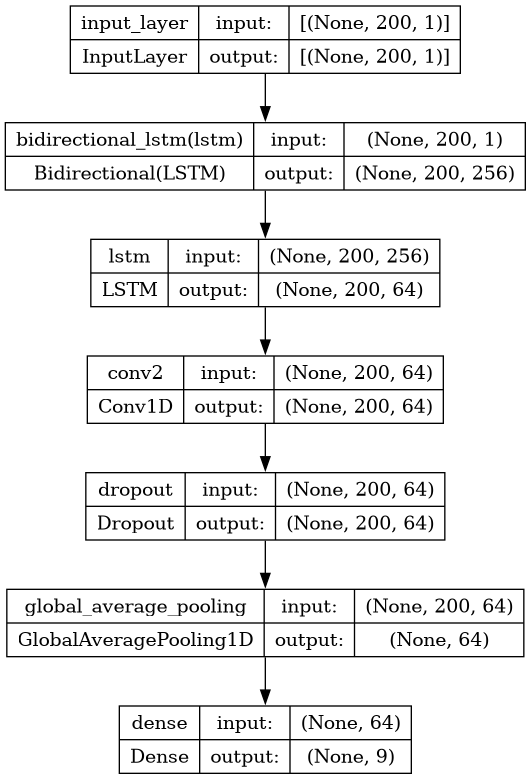

In [15]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [17]:
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 256,
    epochs = 50,
    validation_data=(X_test,y_test),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history


Epoch 1/50
1746/1746 [==============================] - 115s 59ms/step - loss: 0.0186 - val_loss: 0.0093 - lr: 0.0010
Epoch 2/50
1746/1746 [==============================] - 101s 58ms/step - loss: 0.0087 - val_loss: 0.0076 - lr: 0.0010
Epoch 3/50
1746/1746 [==============================] - 101s 58ms/step - loss: 0.0079 - val_loss: 0.0074 - lr: 0.0010
Epoch 4/50
1746/1746 [==============================] - 101s 58ms/step - loss: 0.0076 - val_loss: 0.0071 - lr: 0.0010
Epoch 5/50
1746/1746 [==============================] - 101s 58ms/step - loss: 0.0074 - val_loss: 0.0068 - lr: 0.0010
Epoch 6/50
1746/1746 [==============================] - 102s 58ms/step - loss: 0.0071 - val_loss: 0.0069 - lr: 0.0010
Epoch 7/50
1746/1746 [==============================] - 101s 58ms/step - loss: 0.0066 - val_loss: 0.0063 - lr: 0.0010
Epoch 8/50
1746/1746 [==============================] - 101s 58ms/step - loss: 0.0064 - val_loss: 0.0060 - lr: 0.0010
Epoch 9/50
1746/1746 [==============================] - 

In [18]:
model.save('model_009')